# This first example of sonifications uses Strauss, a python package that aims to be the matplotlib of sonification [here](https://strauss.readthedocs.io/en/latest/) . In order to run this notebook, in addition to the standard fare of numpy etc, you'll need to install strauss and PIL. If you want to make mp3 files, you'll need to install ffmpeg

Strauss is pretty easy to use and hides a lot of the gross parts of working with audio files in python. However, Strauss CANNOT do multiple instruments together at the current moment. There is also a bug in the time evolution of chords to be aware of. Strauss is a great choice if you're looking to do something relatively simple, but you may need to move to Mido (see other notebook) if you want to do something more complex 

In [1]:
import matplotlib.pyplot as plt
import strauss
from strauss.sonification import Sonification
from strauss import channels
from strauss.generator import Sampler
from strauss.score import Score
from strauss.generator import Synthesizer
import IPython.display as ipd
from strauss.sources import Events
import os
import numpy as np
import copy

import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import matplotlib.cm as cm

import time

from FLEX_ed import ExpandGalaxies, BeefIt #this is my edited version of the FLEX code - a copy lives in this directory
#BeefIt takes in filename, rscl_initial, mmax_initial, nmax_initial, new_mmax, new_nmax

#import ffmpeg ----> only need this if you're trying to make mp3 files. Strauss will save out to wav

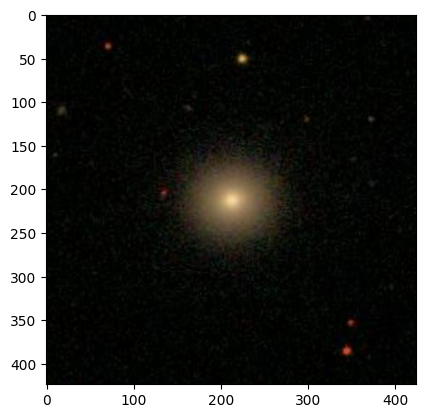

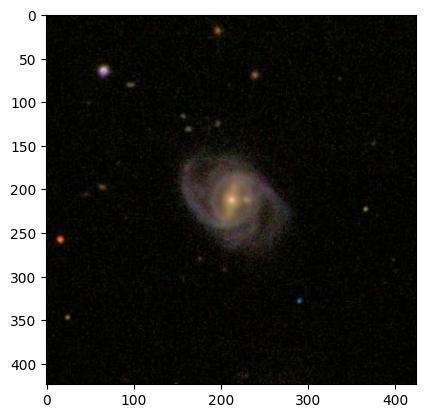

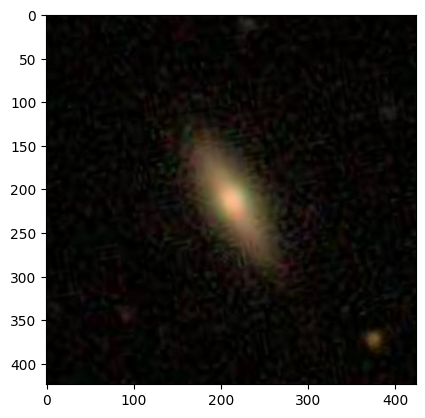

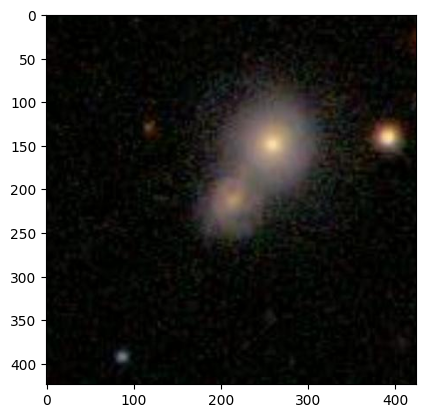

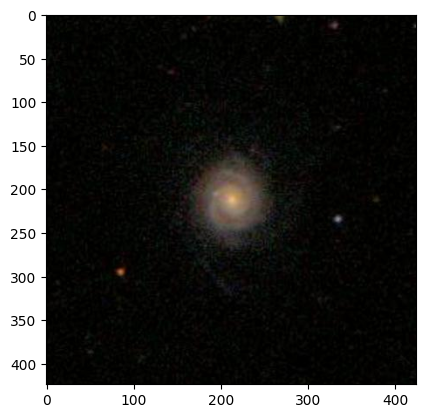

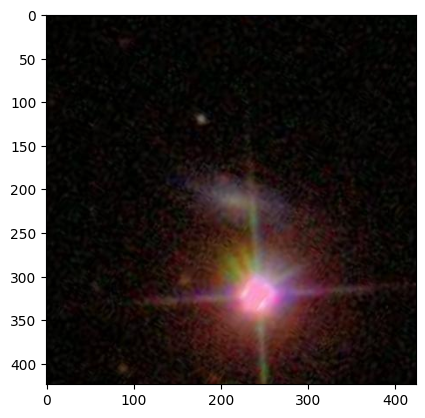

In [2]:
#visually inspecting our chosen galaxies
galaxies = ['GZ2_images/844.jpg', 'GZ2_images/290722.jpg', 'GZ2_images/99129.jpg','GZ2_images/289500.jpg', 'GZ2_images/295140.jpg',
            'GZ2_images/258142.jpg']
for image in galaxies:
    im = Image.open('../'+image)
    a = np.asarray(im)
    plt.figure()
    plt.imshow(a)

# The first step to doing a sonification is to pick a way to map the coefficients to sounds. In the example here, I map the 'n' dimension to notes and the 'm' dimension to octaves. I give a default set of twelve notes in an order that I think generally sounds good, but you can change this! 

In [7]:
def mod_map_to_sounds_octave_ampcutoff(cos_cos, sin_cos, note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#']),
                                      verbose=0):
    if verbose > 0:
        print('using note list: ', note_list)
    #getting the dimensions of m, n from our coefficient arrays
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]
    if len(note_list) < nmax:
        print('more ns than notes - please feed in a different note list!')
        print('looping note list')
        while len(note_list) < nmax:
            note_list = np.append(note_list, note_list)
    if verbose > 0:
        print('mmax, nmax: ', mmax, nmax)
    #using the modulus (amplitude) for these mappings - this removes angular information, you could make other choices!
    modulus = np.sqrt(cos_cos**2 + sin_cos**2)

    abs_max = np.max(modulus)
    note_dict = {}
    
    for m in range(mmax):
        octave = m + 1 #we are starting with the lowest octave being m = 1 instead of 0. This bit here may give you some
        #issues depending on your soundfont and instrument choice - different instruments have different combos of notes + octave
        #ranges. This choice should be fine for piano and for the synth that we'll use in this example, but just a note of caution!
        for n in range(nmax):
            amp = modulus[m,n]/modulus[0,0] #normalizing by the 0,0 term
            if abs(amp) >= 0.01*(abs_max/modulus[0,0]): #will only play terms with amplitude at least 1% of max
                note = note_list[n] + str(octave) #saving out note + octave info - this is the format that Strauss wants, aka something
                #like F2, A3 etc
                note_dict[note] = abs(amp) #saving out the amplitude, too, which could be handy for lots of things, like determining
                #the volume of the different components
    if verbose > 0:
        print('returning full set of notes')
    return note_dict

# doing the mapping - >

#### setting up the things that we need from Strauss, starting with making a 'generator' that will use a soundfont to make sounds from the notes that you give it. A soundfont is just a file that has a bunch of recordings of instruments - you can find mildly to extremely sketchy ones on the internet or make your own! 

In [8]:
test1 = Sampler("../op1 synth 8.sf2", sf_preset=0) #this is a soundfont that I made using a synth, which means that it can do any 
#combo of notes and octaves. The 'sf_preset' here is how you would change to a different instrument if you were using a 'normal' soundfont
test1_generator = copy.copy(test1) 
system = "mono" #opting for 'mono' - aka NOT stereo, no spatial info here! Strauss does let you do spatial info - they have some awesome
#examples on their webpage
length = 3 # length, in seconds, of the sound

In [13]:
for image in galaxies:
    #For this mapping, I want to use 7 m's and 12 n's - this means I'll use all of the twelve notes in the function above
    cos_cos712, sin_cos712 = BeefIt('../'+str(image), rscl_initial = 10, 
                                        mmax_initial = 2, nmax_initial = 10,
                                       new_mmax = 7, new_nmax = 12)
    #doing the actual mapping using the function above
    note_dict = mod_map_to_sounds_octave_ampcutoff(cos_cos712, sin_cos712, verbose=1)

    #this is the Strauss bit, where the magic (aka turning into sound) happens!
    score =  Score([list(note_dict.keys())], length) #strauss uses scores, to make a chord it needs to be in this kind of format:
    #[['A2', 'C2', 'B3']], multiple chords would be [[['A2', 'C2', 'B3'], [['D2', 'E2', 'G3']]
    #then we define the way that the pitch and volume should be 
    data = {'pitch': np.ones(len(note_dict.keys())), #we don't want to change the pitch of any of our notes, and we want constant volume
           'volume': np.ones(len(note_dict.keys()))} #could make volume scale with weight etc!
    #there are a bunch of options you can put into data here, like azimuth angle if you're using stereo
    #we use an 'event' here - from the strauss documentation, events are '... best suited to represent data that can be characterised by 
    #an occurence time', vs an 'object' which is best to 'represent data that evolves continuosly over time' 
    sources = Events(data.keys())
    sources.fromdict(data)
    #the time limit of the mapping, from 0-101% here. We go above 100% so that we dont just truncate super sharply/the notes can play out
    lims = {'time': ('0','101')}
    sources.apply_mapping_functions(map_lims=lims) 
    #last piece here - putting together the score, sources, generator, and whether it is stereo or audio
    soni = Sonification(score, sources, test1_generator, system)
    #rendering!
    soni.render()
    #getting image name with just the galaxy number
    image_name = image.split('/')[1]
    image_name = image_name.split('.')[0]
    #saving out
    soni.save(str(image_name)+'test.wav')
    #converting to MP3 - based on this: https://gist.github.com/kroger/6211862 - uncomment this and install ffmpeg if you want to do this
    #! lame "{image_name}_test.wav" "{image_name}_test.mp3"
    #os.remove(str(image_name)+'_'+'test.wav')

opening image
Reff =  29.11686406230761  Galaxy Radius:  174.70118437384565
getting pixel info, galaxy radius, mask, etc
finding center of image
center of mass estimate 1.1765405126063389 -1.6052432754683108
center finding iteration 0


KeyboardInterrupt: 